In [141]:
import torch
import torchvision

# Perform OCR on image

import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np
import torch
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler, Dataset
from torch.utils.data.distributed import DistributedSampler
from tqdm import tqdm, trange
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertConfig, BertModel, BertPreTrainedModel, get_linear_schedule_with_warmup, AdamW, BertTokenizerFast
from torch.nn import LayerNorm as BertLayerNorm
from PIL import Image
from datasets import Features, Sequence, ClassLabel, Value, Array2D, Array3D
from numpy import asarray

In [142]:
image_loc="pdf_images"
images=[]
for filename in sorted(os.listdir(image_loc)): 
    for f in sorted(os.listdir(os.path.join(image_loc,filename))):
        images.append(Image.open(os.path.join(image_loc,filename,f)))        

In [143]:
images

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1654x2340>,
 <PIL.JpegImagePlugin.JpegImageFile image mode=R

In [144]:
def normalize_bbox(bbox, width, height):
     return [
         (1000 * (bbox[0] / width)),
         (1000 * (bbox[1] / height)),
         (1000 * (bbox[2] / width)),
         (1000 * (bbox[3] / height)),
     ]

In [145]:
def get_all_NH_data_u():
  directory = 'experiment_others/'

  # iterate over files
  
  words=[]
  label = []
  bbox = []
  files=[]
  for filename in sorted(os.listdir(directory)):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        dataraw = open(f) 
        jdata = json.load(dataraw)
        for num in range(len(jdata)):
            word = []
            box = []   
            # boxes=[]
            page = jdata[num] 
            files.append(page['data']['ocr'])
            for i in page['predictions'][0]['result']:             
              val = i['value']
              width=1654
              height=2340
              if 'text' in val.keys():
                word.append(val['text'][0])
                x1=val['x']
                y1=val['y']
                x2=val['x']+val['width']
                y2=val['y']+val['height']
                # box = normalize_bbox([x1,y1,x2,y2], width=width, height=height)
                box.append([x1,y1,x2,y2])
                # boxes.append(box) 
            words.append(word)
            bbox.append(box)
  image=images[:len(words)]               
  all_data = list(zip(image,words,bbox,files))
  u_ocr_data = pd.DataFrame(all_data, columns=['image','word','bbox','files'])
  return u_ocr_data,len(words)

In [146]:
u_ocr_data,x = get_all_NH_data_u()
u_ocr_data

,image,word,bbox,files
0,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[26.3671875, 11.1328125, 40.8203125, 12.5], [...",http://10.129.6.181:8081/pdf_images/NH BC 0007...
1,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[26.3671875, 11.23046875, 40.91796875, 12.597...",http://10.129.6.181:8081/pdf_images/NH BC 0007...
2,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[26.5625, 11.1328125, 41.015625, 12.5], [41.1...",http://10.129.6.181:8081/pdf_images/NH BC 0007...
3,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARIMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[26.3671875, 11.1328125, 40.8203125, 12.5], [...",http://10.129.6.181:8081/pdf_images/NH BC 0007...
4,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, NH, Bc,...","[[27.1484375, 12.79296875, 41.2109375, 14.1601...",http://10.129.6.181:8081/pdf_images/NH BC 0007...
...,...,...,...,...
305,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[27.34375, 13.4765625, 41.30859375, 14.941406...",http://10.129.6.181:8081/pdf_images/NH BC 0016...
306,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[27.1484375, 12.3046875, 41.30859375, 13.6718...",http://10.129.6.181:8081/pdf_images/NH BC 0016...
307,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[27.34375, 12.5, 41.11328125, 13.57421875], [...",http://10.129.6.181:8081/pdf_images/NH BC 0016...
308,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[[27.24609375, 12.5, 41.015625, 13.57421875], ...",http://10.129.6.181:8081/pdf_images/NH BC 0016...


In [147]:
# Load NH data
def get_all_NH_data():
  ####################
  # NH Dataset
  ####################
  # Process the raw Labelled NH Data
  
  directory = 'export_data/'

  # iterate over files
  image=images[x:]
  words = []
  labels = []
  # bbox = []
  boxes = []
  files=[]
  # t_box = []
  # j=0 
  # n=428
  for filename in os.listdir(directory):
    # j=j+1
    # if j<n+1:  
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        dataraw = open(f)
        jdata = json.load(dataraw)   
        for num in range(len(jdata)):
          page = jdata[num]
          # print(page)
          # print()
          word=[]
          bbox=[]
          label=[]
          bbox=[]
          t_box=[]
          file=[]
          z=page['data']['ocr']
          for i in page['annotations'][0]['result']:
            width=i['original_width'] 
            height=i['original_height']
            val = i['value']
            if 'text' in val.keys():
              word.append(val['text'][0])
            if 'labels' in val.keys():
              label.append(val['labels'][0])
            x1=val['x']
            y1=val['y']
            x2=val['x']+val['width']
            y2=val['y']+val['height']
            # box = normalize_bbox([x1,y1,x2,y2], width=width, height=height)
            # box.append([x1,y1,x2,y2]) 
            box=[x1,y1,x2,y2]
            # box = normalize_bbox(box, width=width, height=height) 
            # # print(box)                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                
            # if min(box) < 0 or max(box) > 1000: # another bug in which a box had -4
            #   continue
            # if ((box[3] - box[1]) < 0) or ((box[2] - box[0]) < 0): # another bug in which a box difference was -1
            #   continue
            # #   # ADDED
            t_box.append(box)
            file.append(z)
          for i in range(len(t_box)):
            if i%3==0:
              bbox.append(t_box[i])    
          boxes.append(bbox)
          words.append(word)
          labels.append(label)
          files.append(file) 
  all_data = list(zip(image,words,labels,boxes))
  # Pandas DF of NH data containing WORD, LABEL and BBOX
  ocr_data = pd.DataFrame(all_data, columns=['image','word', 'label','bbox'])

  return ocr_data

In [148]:
# NH data PreProcessing

nh_ocr_l = get_all_NH_data()

# nh_ocr.loc[nh_ocr['label'] == 'field','label'] = 0
# nh_ocr.loc[nh_ocr['label'] == 'field,','label'] = 0
# nh_ocr.loc[nh_ocr['label'] == 'value','label'] = 1
# nh_ocr.loc[nh_ocr['label'] == 'Text','label'] = 2
# nh_ocr.loc[nh_ocr['label'] == 'Handwriting','label'] = 2

print(nh_ocr_l)

                                                 image  \
0    <PIL.JpegImagePlugin.JpegImageFile image mode=...   
1    <PIL.JpegImagePlugin.JpegImageFile image mode=...   
2    <PIL.JpegImagePlugin.JpegImageFile image mode=...   
3    <PIL.JpegImagePlugin.JpegImageFile image mode=...   
4    <PIL.JpegImagePlugin.JpegImageFile image mode=...   
..                                                 ...   
98   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
99   <PIL.JpegImagePlugin.JpegImageFile image mode=...   
100  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
101  <PIL.JpegImagePlugin.JpegImageFile image mode=...   
102  <PIL.JpegImagePlugin.JpegImageFile image mode=...   

                                                  word  \
0    [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
1    [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
2    [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
3    [DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...   
4    [DEPARTM

In [149]:
q=nh_ocr_l['image'].to_numpy()
x=nh_ocr_l['word'].to_numpy()
y=nh_ocr_l['label'].to_numpy()
z=nh_ocr_l['bbox'].to_numpy()

In [150]:
lf=4
val_ocr = nh_ocr_l[0:24]
test_ocr = nh_ocr_l[24:49]
train_ocr = nh_ocr_l[49:49+lf]

In [151]:
train_ocr

,image,word,label,bbox
49,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[Text, Text, Text, Text, field, field, field, ...","[[27.05078125, 8.30078125, 40.91796875, 9.6679..."
50,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[Text, Text, Text, Text, field, field, field, ...","[[27.1484375, 6.73828125, 40.91796875, 8.10546..."
51,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[Text, Text, Text, Text, field, field, field, ...","[[27.1484375, 7.03125, 40.91796875, 8.3984375]..."
52,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[Text, Text, Text, Text, field, field, field, ...","[[27.05078125, 13.4765625, 40.72265625, 14.550..."


In [152]:
q_u=u_ocr_data['image'].to_numpy()
x_u=u_ocr_data['word'].to_numpy()
z_u=u_ocr_data['bbox'].to_numpy()

In [153]:
x_u

array([list(['DEPARTMENT', 'OF', 'LABORATORY', 'MEDICINE', 'MRN', 'Name', 'Age', '/Sex', 'Sample', 'No', 'Consulting', 'DR', 'Patient', 'Address', 'NH', 'BL', '0071', 'Department', 'Specimen', 'Visit', 'Type', 'CARDIOLOOY-ADUET', 'SERUM', 'IP', '73', 'Year(s)/Male', 'Dr.Kannan', 'J', 'Collected', 'On', '27/01/2022', '03:42', 'PM', 'Referred', 'DR', 'Dr.Kannan', 'J', 'Received', 'On', '27/01/2022', '04:34', 'PM', 'Reported', 'On', '27/01/2022', '06:43', 'PM', 'ReportType', 'Final', 'BIOCHEMISTRY', 'Result', '9.265', 'H', 'Test', 'Unit', 'MIU/mL', 'Biological', 'Reference', 'Interval', '0.400-4.049', 'TSH', '(THYROID', 'STIMULATING', 'HORMONE)', 'Enhanced', 'chemiluminescence', 'Dr.', 'lyshwarya', 'U', 'Associate', 'Consultant', 'MD', 'Biochemistry', 'Page', '1/6']),
       list(['DEPARTMENT', 'OF', 'LABORATORY', 'MEDICINE', 'MRN', 'Name', 'Age/Sex', 'Sample', 'No', 'Consulting', 'DR', 'Patient', 'Address', 'Department', 'Specimen', 'Visit', 'Type', 'Collected', 'On', 'Referred', 'DR', '

In [154]:
y_u=[]
for i in range(len(x_u)):
    temp=[]
    for j in range(len(x_u[i])):
        temp.append("Text")
    y_u.append(temp)
# np.array(y_u)    
print(len(y_u))

310


In [155]:
y_mod=[]
for i in range(len(y[49+lf:])):
    temp=[]
    for j in range(len(y[49+lf:][i])):
        temp.append("Text")
    y_mod.append(temp)    
# x_u.append(x[50+lf:])
q_u_mod=np.concatenate((q[49+lf:], q_u), axis=0)
x_u_mod=np.concatenate((x[49+lf:], x_u), axis=0)
y_u_mod=np.concatenate((y_mod, y_u), axis=0)
z_u_mod=np.concatenate((z[49+lf:], z_u), axis=0)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [156]:
all_data = list(zip(q_u_mod,x_u_mod,y_u_mod,z_u_mod)) 
# Pandas DF of cord data containing WORD, LABEL and BBOX
u_ocr_data = pd.DataFrame(all_data, columns=['image','word', 'label','bbox'])
# ocr_data['bbox']

In [157]:
u_ocr_data['label']

0      [Text, Text, Text, Text, Text, Text, Text, Tex...
1      [Text, Text, Text, Text, Text, Text, Text, Tex...
2      [Text, Text, Text, Text, Text, Text, Text, Tex...
3      [Text, Text, Text, Text, Text, Text, Text, Tex...
4      [Text, Text, Text, Text, Text, Text, Text, Tex...
                             ...                        
355    [Text, Text, Text, Text, Text, Text, Text, Tex...
356    [Text, Text, Text, Text, Text, Text, Text, Tex...
357    [Text, Text, Text, Text, Text, Text, Text, Tex...
358    [Text, Text, Text, Text, Text, Text, Text, Tex...
359    [Text, Text, Text, Text, Text, Text, Text, Tex...
Name: label, Length: 360, dtype: object

In [158]:
cage_words_u=[item for sublist in train_ocr['word'] for item in sublist]
cage_bbox_u=[item for sublist in train_ocr['bbox'] for item in sublist]
cage_labels_u=[item for sublist in train_ocr['label'] for item in sublist]
all_data = list(zip(cage_words_u,cage_labels_u,cage_bbox_u))  
# Pandas DF of cord data containing WORD, LABEL and BBOX
train_ocr_ = pd.DataFrame(all_data, columns=['word', 'label','bbox'])
train_ocr_.loc[train_ocr_['label'] == 'field','label'] = 0
train_ocr_.loc[train_ocr_['label'] == 'field,','label'] = 0
train_ocr_.loc[train_ocr_['label'] == 'value','label'] = 1
train_ocr_.loc[train_ocr_['label'] == 'Text','label'] = 2
train_ocr_.loc[train_ocr_['label'] == 'Handwriting','label'] = 2
len(train_ocr_)

525

In [159]:
cage_words_u=[item for sublist in val_ocr['word'] for item in sublist]
cage_bbox_u=[item for sublist in val_ocr['bbox'] for item in sublist]
cage_labels_u=[item for sublist in val_ocr['label'] for item in sublist]
all_data = list(zip(cage_words_u,cage_labels_u,cage_bbox_u))  
# Pandas DF of cord data containing WORD, LABEL and BBOX
val_ocr_ = pd.DataFrame(all_data, columns=['word', 'label','bbox'])
val_ocr_.loc[val_ocr_['label'] == 'field','label'] = 0
val_ocr_.loc[val_ocr_['label'] == 'field,','label'] = 0
val_ocr_.loc[val_ocr_['label'] == 'value','label'] = 1
val_ocr_.loc[val_ocr_['label'] == 'Text','label'] = 2
val_ocr_.loc[val_ocr_['label'] == 'Handwriting','label'] = 2
len(val_ocr_)

3637

In [160]:
cage_words_u=[item for sublist in test_ocr['word'] for item in sublist]
cage_bbox_u=[item for sublist in test_ocr['bbox'] for item in sublist]
cage_labels_u=[item for sublist in test_ocr['label'] for item in sublist]
all_data = list(zip(cage_words_u,cage_labels_u,cage_bbox_u))  
# Pandas DF of cord data containing WORD, LABEL and BBOX
test_ocr_ = pd.DataFrame(all_data, columns=['word', 'label','bbox'])
test_ocr_.loc[test_ocr_['label'] == 'field','label'] = 0
test_ocr_.loc[test_ocr_['label'] == 'field,','label'] = 0
test_ocr_.loc[test_ocr_['label'] == 'value','label'] = 1
test_ocr_.loc[test_ocr_['label'] == 'Text','label'] = 2
test_ocr_.loc[test_ocr_['label'] == 'Handwriting','label'] = 2
len(test_ocr_)

3771

In [161]:
cage_words_u=[item for sublist in u_ocr_data['word'] for item in sublist]
cage_bbox_u=[item for sublist in u_ocr_data['bbox'] for item in sublist]
cage_labels_u=[item for sublist in u_ocr_data['label'] for item in sublist]
all_data = list(zip(cage_words_u,cage_labels_u,cage_bbox_u))  
# Pandas DF of cord data containing WORD, LABEL and BBOX
u_ocr_data_ = pd.DataFrame(all_data, columns=['word', 'label','bbox'])
u_ocr_data_.loc[u_ocr_data_['label'] == 'field','label'] = 0
u_ocr_data_.loc[u_ocr_data_['label'] == 'field,','label'] = 0
u_ocr_data_.loc[u_ocr_data_['label'] == 'value','label'] = 0
u_ocr_data_.loc[u_ocr_data_['label'] == 'Text','label'] = 0
u_ocr_data_.loc[u_ocr_data_['label'] == 'Handwriting','label'] = 0
len(u_ocr_data_)

54929

In [162]:
# # For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
# import enum
# ABSTAIN = -1
# # Create Label Class
# class ClassLabels(enum.Enum):
#     FIELD = 0
#     VALUE = 1
#     TEXT = 2
# headertrigger = {"department","of","labarotory","medicine"}
# patdet_f_trigger = {"mrn","name","age","age/sex","sex","sample","no","consulting","dr","patient","address","department","specimen","type","visit","collected","on","referred","received","report","reported"}
# patdet_v_trigger = {"nh","year","year(s)","male","dr","serum","ip","am","pm","final","adult","dermatology","op","plasma","diabetology","blood","urine","pulmonology","cardiac","surgical","oncology","medicine","neurology","gastroenterology","vascular","endovascular","anesthesiology","nephrology","diabetology","administration","emergency",""}
# text_trigger = {"test","result","biochemistry","unit","biological","interval","page","notes","mg","dl","mg/dl","mmol","comment"}

# from spear4HighFidelity.spear.labeling import labeling_function, ABSTAIN, preprocessor, continuous_scorer
# import re

# @preprocessor()
# def convert_word_lower(x):
#     word = x[0].lower().strip()
#     bbox = x[1]
#     return [word,bbox]

# # Labelling function for patient details 'Field'
# @labeling_function(resources=dict(keywords=patdet_f_trigger),pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF1(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN
# # Labelling function for patient details 'Field'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF2(x):
#     # print(type(x[1][0]))
#     if ((x[1][0]<9) and (x[1][1] < 27))or((x[1][0]>49 and x[1][0]<55) and (x[1][1] < 27)):
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN

# # Labelling function for patient details 'Value'
# @labeling_function(resources=dict(keywords=patdet_v_trigger),pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF3(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for patient details 'Value'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF4(x):
#     if ((x[1][0]>19 and x[1][0]<23) and (x[1][1]<27))or((x[1][0]>61 and x[1][0]<65) and (x[1][1] < 27)):
#         return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for Table 'Field'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF5(x):
#     if ((x[1][0]<9) and (x[1][1]>33 and x[1][1]<78)):
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN

# # Labelling function for Table 'Value'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF6(x):
#     if x[0].isalnum() and (((x[1][0]>42 and x[1][0]<55) and (x[1][1]>33 and x[1][1]<78))):
#           return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for 'Text'
# @labeling_function(resources=dict(keywords=text_trigger),pre=[convert_word_lower],label=ClassLabels.TEXT)
# def LF7(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.TEXT
#     else:
#         return ABSTAIN
    
# # # Labelling function for patient details 'Header'
# # @labeling_function(resources=dict(keywords=headertrigger),pre=[convert_word_lower],label=ClassLabels.HEADER)
# # def LF8(x,**kwargs):
# #     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
# #         return ClassLabels.HEADER
# #     else:
# #         return ABSTAIN

# @labeling_function(pre=[convert_word_lower],label=ClassLabels.TEXT)
# def LF8(x,**kwargs):    
#     if LF1(x)==(None, None) and LF2(x)==(None, None) and LF3(x)==(None, None) and LF4(x)==(None, None) and LF5(x)==(None, None):
#         return ClassLabels.TEXT
#     else:
#         return ABSTAIN    

In [163]:
# For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
import enum
ABSTAIN = -1
# Create Label Class
class ClassLabels(enum.Enum):
    FIELD = 0
    VALUE = 1
    TEXT = 2
headertrigger = {"department","of","labarotory","medicine"}
patdet_f_trigger = {"mrn","name","age","age/sex","sex","sample","no","consulting","dr","patient","address","department","specimen","type","visit","collected","on","referred","received","report","reported"}
patdet_v_trigger = {"nh","year","year(s)","male","dr","serum","ip","am","pm","final","adult","dermatology","op","plasma","diabetology","blood","urine","pulmonology","cardiac","surgical","oncology","medicine","neurology","gastroenterology","vascular","endovascular","anesthesiology","nephrology","diabetology","administration","emergency",""}
text_trigger = {"test","result","biochemistry","unit","biological","interval","page","notes","mg","dl","mg/dl","mmol","comment"}

from spear4HighFidelity.spear.labeling import labeling_function, ABSTAIN, preprocessor, continuous_scorer
import re

@preprocessor()
def convert_word_lower(x):
    word = x[0].lower().strip()
    bbox = x[1]
    return [word,bbox]

# Labelling function for patient details 'Field'
@labeling_function(resources=dict(keywords=patdet_f_trigger),pre=[convert_word_lower],label=ClassLabels.FIELD)
def LF1(x,**kwargs):
    if len(kwargs["keywords"].intersection(x[0].split())) > 0:
        return ClassLabels.FIELD
    else:
        return ABSTAIN
# Labelling function for patient details 'Field'
@labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
def LF2(x):
    # print(type(x[1][0]))
    if ((x[1][0]>5.5 and x[1][1]>13) and (x[1][2]<19 and x[1][3]<28) or (x[1][0]>49 and x[1][1]>13) and (x[1][2]<60 and x[1][3]<33)):
        return ClassLabels.FIELD
    else:
        return ABSTAIN
    
# Labelling function for patient details 'Value'
@labeling_function(resources=dict(keywords=patdet_v_trigger),pre=[convert_word_lower],label=ClassLabels.VALUE)
def LF3(x,**kwargs):
    if len(kwargs["keywords"].intersection(x[0].split())) > 0:
        return ClassLabels.VALUE
    else:
        return ABSTAIN

# Labelling function for patient details 'Value'
@labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
def LF4(x):
    if ((x[1][0]>19 and x[1][1]>13) and (x[1][2]<48 and x[1][3]<31) or (x[1][0]>61 and x[1][1]>14) and (x[1][2]<85 and x[1][3]<33)):
        return ClassLabels.VALUE
    else:
        return ABSTAIN

# Labelling function for Table 'Field'
@labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
def LF5(x):
    if ((x[1][0]>6 and x[1][1]>41) and (x[1][2]<45 and x[1][3]<71.9)):
        return ClassLabels.FIELD
    else:
        return ABSTAIN

# Labelling function for Table 'Value'
@labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
def LF6(x):
    if x[0].isalnum() and (((x[1][0]>42 and x[1][0]<55) and (x[1][1]>33 and x[1][1]<78))):
        return ClassLabels.VALUE
    else:
        return ABSTAIN
# if x[0].isalnum() and ((x[1][0]>42 and x[1][1]>40) and (x[1][2]<55 and x[1][3]<75)):
# Labelling function for 'Text'
@labeling_function(resources=dict(keywords=text_trigger),pre=[convert_word_lower],label=ClassLabels.TEXT)
def LF7(x,**kwargs):
    if len(kwargs["keywords"].intersection(x[0].split())) > 0:
        return ClassLabels.TEXT
    else:
        return ABSTAIN
    
# # Labelling function for patient details 'Header'
# @labeling_function(resources=dict(keywords=headertrigger),pre=[convert_word_lower],label=ClassLabels.HEADER)
# def LF8(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.HEADER
#     else:
#         return ABSTAIN

@labeling_function(pre=[convert_word_lower],label=ClassLabels.TEXT)
def LF8(x,**kwargs):    
    if LF1(x)==(None, None) and LF2(x)==(None, None) and LF3(x)==(None, None) and LF4(x)==(None, None) and LF5(x)==(None, None) and LF6(x)==(None,None) and LF7(x)==(None,None):
        return ClassLabels.TEXT
    else:
        return ABSTAIN    

In [164]:
# # For clarity, we define constants to represent the class labels for spam, ham, and abstaining.
# import enum

# # enum to hold the class labels
# # ABSTAIN = -1

# # Create Label Class
# class ClassLabels(enum.Enum):
#     FIELD = 0
#     VALUE = 1
#     TEXT = 2


# THRESHOLD = 0.8

# headertrigger = {"department","of","labarotory","medicine"}
# patdet_f_trigger = {"mrn","name","age","age/sex","sex","sample","no","consulting","dr","patient","address","department","specimen","type","visit","collected","on","referred","received","report","reported"}
# patdet_v_trigger = {"nh","year","year(s)","male","dr","serum","ip","am","pm","final","adult","dermatology","op","plasma","diabetology","blood","urine","pulmonology","cardiac","surgical","oncology","medicine","neurology","gastroenterology","vascular","endovascular","anesthesiology","nephrology","diabetology","administration","emergency",""}
# text_trigger = {"test","result","biochemistry","unit","biological","interval","page","notes","mg","dl","mg/dl","mmol","comment"}

# from spear4HighFidelity.spear.labeling import labeling_function, ABSTAIN, preprocessor, continuous_scorer
# import re


# @preprocessor()
# def convert_word_lower(x):
#     word = x[0].lower().strip()
#     bbox = x[1]
#     return [word,bbox]

# # Labelling function for patient details 'Field'
# @labeling_function(resources=dict(keywords=patdet_f_trigger),pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF1(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN
# # Labelling function for patient details 'Field'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF2(x):
#     if ((x[1][0]<9) and (x[1][1] < 27))or((x[1][0]>49 and x[1][0]<55) and (x[1][1] < 27)):
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN

# # Labelling function for patient details 'Value'
# @labeling_function(resources=dict(keywords=patdet_v_trigger),pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF3(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for patient details 'Value'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF4(x):
#     if ((x[1][0]>19 and x[1][0]<23) and (x[1][1]<27))or((x[1][0]>61 and x[1][0]<65) and (x[1][1] < 27)):
#         return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for Table 'Field'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.FIELD)
# def LF5(x):
#     if ((x[1][0]<9) and (x[1][1]>33 and x[1][1]<78)):
#         return ClassLabels.FIELD
#     else:
#         return ABSTAIN

# # Labelling function for Table 'Value'
# @labeling_function(pre=[convert_word_lower],label=ClassLabels.VALUE)
# def LF6(x):
#     if x[0].isalnum() and (((x[1][0]>42 and x[1][0]<55) and (x[1][1]>33 and x[1][1]<78))):
#           return ClassLabels.VALUE
#     else:
#         return ABSTAIN

# # Labelling function for 'Text'
# @labeling_function(resources=dict(keywords=text_trigger),pre=[convert_word_lower],label=ClassLabels.TEXT)
# def LF7(x,**kwargs):
#     if len(kwargs["keywords"].intersection(x[0].split())) > 0:
#         return ClassLabels.TEXT
#     else:
#         return ABSTAIN

# @labeling_function(pre=[convert_word_lower],label=ClassLabels.TEXT)
# def LF8(x,**kwargs):    
#     if LF1(x)==(None, None) and LF2(x)==(None, None) and LF3(x)==(None, None) and LF4(x)==(None, None) and LF5(x)==(None, None):
#         return ClassLabels.TEXT
#     else:
#         return ABSTAIN   

In [165]:
from spear4HighFidelity.spear.labeling import LFSet

LFS = [LF1,
    LF2,
    LF3,
    LF4,
    LF5,
    LF6,
    LF7,
    LF8
      ]

rules = LFSet("NH_LF")
rules.add_lf_list(LFS)

In [166]:
# LF test run
from spear4HighFidelity.spear.labeling import PreLabels,PreLabelsWithContext
import numpy as np

X = train_ocr_[['word','bbox']].to_numpy()
Y = train_ocr_['label'].to_numpy()
bbox = np.array(list(train_ocr_['bbox']))

# Y
#############################
# Modified Prelabels
#############################
nh_noisy_labels = PreLabelsWithContext(name="nh",
                            data=X,
                            gold_labels=Y,
                            rules=rules,
                            labels_enum=ClassLabels,num_classes=3) 

L,S = nh_noisy_labels.get_labels()

100%|██████████| 525/525 [00:00<00:00, 54854.14it/s]


In [167]:
len(bbox)

525

In [168]:
X_T = train_ocr_[['word','bbox']].to_numpy()
Y_T = train_ocr_['label'].to_numpy() 
X_U = u_ocr_data_[['word','bbox']].to_numpy()
Y_U = u_ocr_data_['label'].to_numpy()
bbox_T = np.array(list(train_ocr_['bbox']))
test_size = len(X_T)
U_size = len(X_U)
bbox_U = np.array(list(u_ocr_data_['bbox'])) 
n_lfs = len(rules.get_lfs())

# print(n_lfs)

# Paths
path_json = 'NH_Paths/nh_json_mod_1%_v2.json'
T_path_pkl = 'NH_Paths/nh_pickle_mod_T_1%_v2.pkl' #test data - have true labels
U_path_pkl = 'NH_Paths/nh_pickle_mod_U_1%_v2.pkl' #unlabelled data - don't have true labels

log_path_cage_1 = 'NH_Paths/nh_mod_log_1_1%_v2.txt' #cage is an algorithm, can be found below
params_path = 'NH_Paths/nh_mod_params_1%_v2.pkl' #file path to store parameters of Cage, used below

# Generate Noisy labels
from spear4HighFidelity.spear.labeling import PreLabels

nh_noisy_labels_lab = PreLabels(name="nh",
                               data=X_T,
                               gold_labels=Y_T,
                               data_feats=bbox_T,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L_lab,S_lab = nh_noisy_labels_lab.get_labels()                               
nh_noisy_labels_lab.generate_pickle(T_path_pkl)

nh_noisy_labels.generate_json(path_json) #generating json files once is enough

nh_noisy_labels_unl = PreLabels(name="nh",
                               data=X_U,
                               data_feats=bbox_U,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3) #note that we don't pass gold_labels here, for the unlabelled data
L_unl,S_unl = nh_noisy_labels_unl.get_labels()
nh_noisy_labels_unl.generate_pickle(U_path_pkl)

  0%|          | 0/54929 [00:00<?, ?it/s]

100%|██████████| 54929/54929 [00:01<00:00, 48404.58it/s]


In [169]:
# Preprocessing
X_TI = test_ocr_[['word','bbox']].to_numpy()
Y_TI = test_ocr_['label'].to_numpy()
X_D = val_ocr_[['word','bbox']].to_numpy()
Y_D = val_ocr_['label'].to_numpy()
bbox_TI = np.array(list(test_ocr_['bbox'])) 
bbox_D = np.array(list(val_ocr_['bbox'])) 
test_size = len(X_TI)
Z_size = len(X_D)
# n_lfs = len(rules.get_lfs())

# print(n_lfs)

# Paths
# path_json = 'Cages_Paths/cord_json.json'
TI_path_pkl = 'NH_Paths/nh_test_pickle_mod_T_1%_v2.pkl' #test data - have true labels
Z_path_pkl = 'NH_Paths/nh_dev_pickle_mod_U_1%_v2.pkl' #unlabelled data - don't have true labels

# log_path_cage_1 = 'Cages_Paths/cord_log_1.txt' #cage is an algorithm, can be found below
# params_path = 'Cages_Paths/cord_params.pkl' #file path to store parameters of Cage, used below


# Generate Noisy labels
from spear4HighFidelity.spear.labeling import PreLabels

nh_noisy_labels_test = PreLabels(name="nh",
                               data=X_TI,
                               gold_labels=Y_TI,
                               data_feats=bbox_TI,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L_test,S_test = nh_noisy_labels_test.get_labels()                               
nh_noisy_labels_test.generate_pickle(TI_path_pkl)

# cord_noisy_labels.generate_json(path_json) #generating json files once is enough

nh_noisy_labels_val = PreLabels(name="nh",
                               data=X_D,
                               gold_labels=Y_D,
                               data_feats=bbox_D,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3) #note that we don't pass gold_labels here, for the unlabelled data
nh_noisy_labels_val.generate_pickle(Z_path_pkl)
L_val,S_val = nh_noisy_labels_val.get_labels()

100%|██████████| 3637/3637 [00:00<00:00, 60188.85it/s]


In [170]:
from spear4HighFidelity.spear.cage import Cage
cage = Cage(path_json = path_json, n_lfs = n_lfs)

probs = cage.fit_and_predict_proba(path_pkl = U_path_pkl, path_test = T_path_pkl, path_log = log_path_cage_1, \
                                   qt = 0.9, qc = np.array([0.85]), metric_avg = ['micro'], n_epochs = 200, lr = 0.01)
labels = np.argmax(probs, 1)
print("probs shape: ", probs.shape)  
print("labels shape: ",labels.shape)

100%|██████████| 200/200 [00:09<00:00, 20.23it/s]

final_test_accuracy_score: 0.8495238095238096
test_average_metric: micro	final_test_f1_score: 0.8495238095238096
probs shape:  (54929, 3)
labels shape:  (54929,)


In [171]:
labels

array([1, 2, 2, ..., 2, 2, 2])

In [172]:
from spear4HighFidelity.spear.labeling import PreLabels
import numpy as np

R = np.zeros((X.shape[0],len(rules.get_lfs())))

cord_noisy_labels = PreLabels(name="cord",
                               data=X,
                               data_feats = bbox,
                               gold_labels=Y,
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
L,S = cord_noisy_labels.get_labels()

100%|██████████| 525/525 [00:00<00:00, 49783.18it/s]


In [173]:
from spear4HighFidelity.spear.labeling import LFAnalysis
analyse = cord_noisy_labels.analyse_lfs(plot=False)

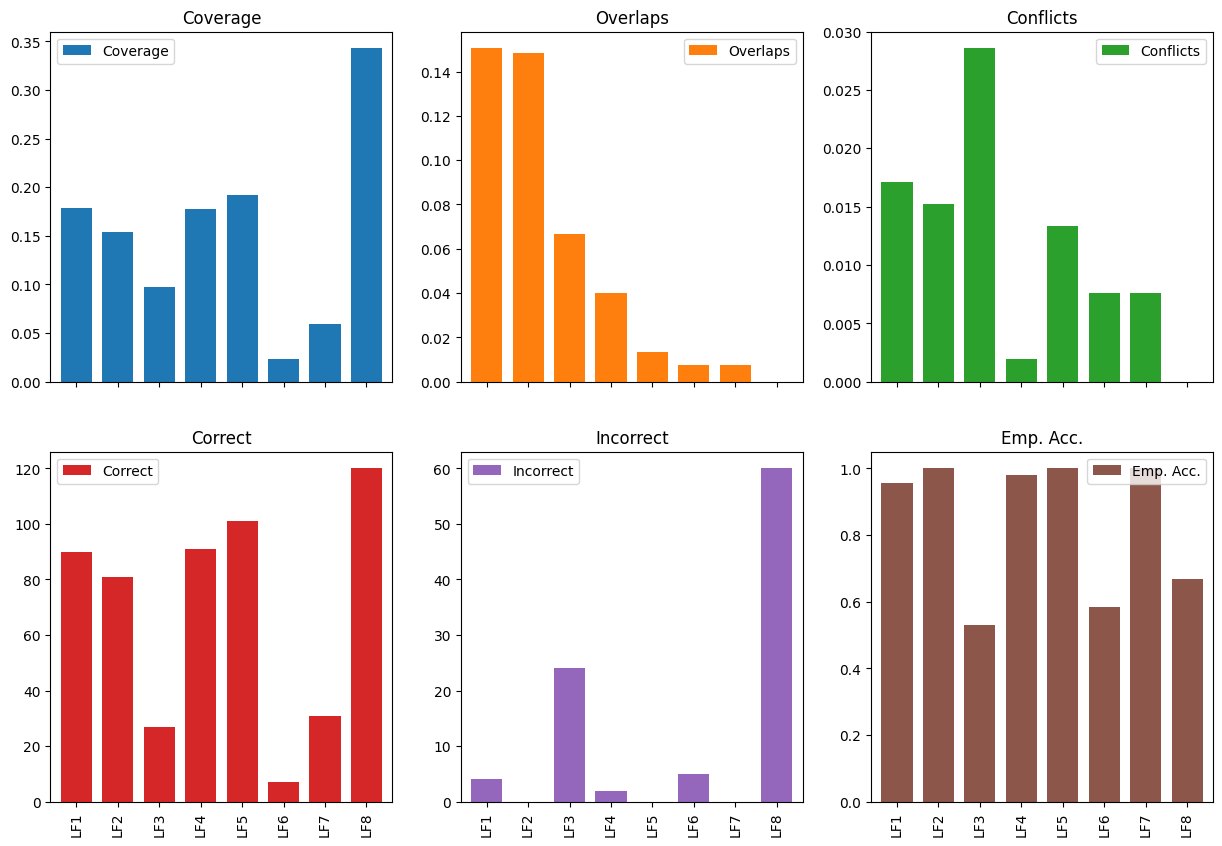

,Polarity,Coverage,Overlaps,Conflicts,Correct,Incorrect,Emp. Acc.
LF1,"[-1.0, 0.0]",0.179048,0.150476,0.017143,90,4,0.957447
LF2,"[-1.0, 0.0]",0.154286,0.148571,0.015238,81,0,1.000000
LF3,"[-1.0, 1.0]",0.097143,0.066667,0.028571,27,24,0.529412
LF4,"[-1.0, 1.0]",0.177143,0.040000,0.001905,91,2,0.978495
LF5,"[-1.0, 0.0]",0.192381,0.013333,0.013333,101,0,1.000000
LF6,"[-1.0, 1.0]",0.022857,0.007619,0.007619,7,5,0.583333
LF7,"[-1.0, 2.0]",0.059048,0.007619,0.007619,31,0,1.000000
LF8,"[-1.0, 2.0]",0.342857,0.000000,0.000000,120,60,0.666667


In [174]:
analyse
from spear4HighFidelity.spear.labeling import LFAnalysis

analyse = cord_noisy_labels.analyse_lfs(plot=True)

result = analyse.head(16)
display(result)

In [175]:
#layoutlm

In [176]:
import torch
import torchvision

# Perform OCR on image

import matplotlib.pyplot as plt
import os
import json
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
import numpy as np

In [177]:
def normalize_bbox(bbox, width, height):
     return [
         int(1000 * (bbox[0] / width)),
         int(1000 * (bbox[1] / height)),
         int(1000 * (bbox[2] / width)),
         int(1000 * (bbox[3] / height)),
     ]

In [178]:
def change(lab):
    temp=lab
    for i in range(len(temp)):
        for j in range(len(temp[i])):
            # if (y[i][j] == "header"):
            #   y[i][j] = 0
            if (temp[i][j] == 'field'):
                temp[i][j] = 0
            elif (temp[i][j] == 'Handwriting'):
                temp[i][j] = 2       
            elif (temp[i][j] == 'value'):
                temp[i][j] = 1
            elif (temp[i][j] == 'Text'):
                temp[i][j] = 2 
            elif (temp[i][j] == 'field,'):
                temp[i][j] = 0
    return temp    

In [179]:
label_=change(train_ocr['label'].to_list())

In [180]:
len(train_ocr['word'])

4

In [181]:
train_ocr

,image,word,label,bbox
49,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ...","[[27.05078125, 8.30078125, 40.91796875, 9.6679..."
50,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[27.1484375, 6.73828125, 40.91796875, 8.10546..."
51,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...","[[27.1484375, 7.03125, 40.91796875, 8.3984375]..."
52,<PIL.JpegImagePlugin.JpegImageFile image mode=...,"[DEPARTMENT, OF, LABORATORY, MEDICINE, MRN, Na...","[2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, ...","[[27.05078125, 13.4765625, 40.72265625, 14.550..."


In [182]:
L_u=[]
for i in range(49,len(train_ocr['word'])+49):
    x=train_ocr['word'][i]
    y=train_ocr['bbox'][i]
    data = list(zip(x,y)) 
    ocr_data = pd.DataFrame(data, columns=['word','bbox'])
    inputs=ocr_data[['word','bbox']].to_numpy()
    nh_noisy_labels_test = PreLabels(name="nh",
                               data=inputs,
                               gold_labels=np.array(label_[i-49]),
                               data_feats=np.array(list(train_ocr['bbox'][i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = nh_noisy_labels_test.get_labels()
    L_u.append(L.tolist())    

100%|██████████| 92/92 [00:00<00:00, 56168.26it/s]


In [183]:
for i in range(len(L_u)):
    for j in range(len(L_u[i])):
        for k in range(len(L_u[i][j])):
            if L_u[i][j][k]==None:
                L_u[i][j][k]=-1

In [184]:
lab_u=change(u_ocr_data['label'].to_list())
lab_val=change(val_ocr['label'].to_list())
lab_test=change(test_ocr['label'].to_list())    

In [185]:
len(lab_u)

360

In [186]:
L_w=[]
for i in range(len(u_ocr_data['word'])):
    x=u_ocr_data['word'][i]
    y=u_ocr_data['bbox'][i]
    data = list(zip(x,y)) 
    ocr_data = pd.DataFrame(data, columns=['word','bbox'])
    inputs=ocr_data[['word','bbox']].to_numpy()
    nh_noisy_labels_test = PreLabels(name="nh",
                               data=inputs,
                               gold_labels=np.array(lab_u[i]),
                               data_feats=np.array(list(u_ocr_data['bbox'][i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = nh_noisy_labels_test.get_labels()
    L_w.append(L.tolist())    

  0%|          | 0/175 [00:00<?, ?it/s]

100%|██████████| 88/88 [00:00<00:00, 57375.84it/s]


In [187]:
for i in range(len(L_w)):
    for j in range(len(L_w[i])):
        for k in range(len(L_w[i][j])):
            if L_w[i][j][k]==None:
                L_w[i][j][k]=-1

In [188]:
len(L_w)

360

In [189]:
L_w_dev=[]
for i in range(len(val_ocr['word'])):
    x=val_ocr['word'][i]
    y=val_ocr['bbox'][i]
    data = list(zip(x,y)) 
    ocr_data = pd.DataFrame(data, columns=['word','bbox'])
    inputs=ocr_data[['word','bbox']].to_numpy()
    nh_noisy_labels_test = PreLabels(name="nh",
                               data=inputs,
                               gold_labels=np.array(lab_val[i]),
                               data_feats=np.array(list(val_ocr['bbox'][i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = nh_noisy_labels_test.get_labels()
    L_w_dev.append(L.tolist())

100%|██████████| 236/236 [00:00<00:00, 58446.84it/s]


In [190]:
L.tolist()

[[0, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, None, None, None, None, 2],
 [None, None, 1, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, 1, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [None, None, None, 1, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None, None, None],
 [0, 0, None, None, None, None,

In [191]:
for i in range(len(L_w_dev)):
    for j in range(len(L_w_dev[i])):
        for k in range(len(L_w_dev[i][j])):
            if L_w_dev[i][j][k]==None:
                L_w_dev[i][j][k]=-1
            list(L_w_dev[i][j])    

In [192]:
L_w_dev

[[[0, -1, -1, -1, -1, -1, -1, -1],
  [-1, -1, -1, -1, -1, -1, -1, 2],
  [-1, -1, -1, -1, -1, -1, -1, 2],
  [-1, -1, 1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, 1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [0, 0, -1, -1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, 1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -1],
  [-1, -1, -1, 1, -1, -1, -1, -

In [193]:
L_w_test=[]
for i in range(24,len(test_ocr['word'])+24):
    x=test_ocr['word'][i]
    y=test_ocr['bbox'][i]
    data = list(zip(x,y)) 
    ocr_data = pd.DataFrame(data, columns=['word','bbox'])
    inputs=ocr_data[['word','bbox']].to_numpy()
    nh_noisy_labels_test = PreLabels(name="nh",
                               data=inputs,
                               gold_labels=np.array(lab_test[i-24]),
                               data_feats=np.array(list(test_ocr['bbox'][i])),
                               rules=rules,
                               labels_enum=ClassLabels,
                               num_classes=3)
    L,S = nh_noisy_labels_test.get_labels()
    L_w_test.append(L.tolist())

100%|██████████| 180/180 [00:00<00:00, 56345.60it/s]


In [194]:
for i in range(len(L_w_test)):
    for j in range(len(L_w_test[i])):
        for k in range(len(L_w_test[i][j])):
            if L_w_test[i][j][k]==None:
                L_w_test[i][j][k]=-1

In [195]:
len(L_w_test)

25

In [196]:
train_image=train_ocr['image'].to_numpy()
train_token=train_ocr['word'].to_numpy()
train_label=train_ocr['label'].to_numpy()  
train_bbox=train_ocr['bbox'].to_numpy() 
L_u=np.array(L_u)

/tmp/ipykernel_2485579/2521991251.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L_u=np.array(L_u)


In [197]:
u_ocr_data['image']


0      <PIL.JpegImagePlugin.JpegImageFile image mode=...
1      <PIL.JpegImagePlugin.JpegImageFile image mode=...
2      <PIL.JpegImagePlugin.JpegImageFile image mode=...
3      <PIL.JpegImagePlugin.JpegImageFile image mode=...
4      <PIL.JpegImagePlugin.JpegImageFile image mode=...
                             ...                        
355    <PIL.JpegImagePlugin.JpegImageFile image mode=...
356    <PIL.JpegImagePlugin.JpegImageFile image mode=...
357    <PIL.JpegImagePlugin.JpegImageFile image mode=...
358    <PIL.JpegImagePlugin.JpegImageFile image mode=...
359    <PIL.JpegImagePlugin.JpegImageFile image mode=...
Name: image, Length: 360, dtype: object

In [198]:
train_u_image=u_ocr_data['image'].to_numpy()
train_u_token=u_ocr_data['word'].to_numpy()
train_u_label=u_ocr_data['label'].to_numpy() 
train_u_bbox=u_ocr_data['bbox'].to_numpy()
L_w_u=np.array(L_w)

/tmp/ipykernel_2485579/17601492.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L_w_u=np.array(L_w)


In [199]:
len(L_w_u)

360

In [200]:
val_image=val_ocr['image'].to_numpy()
val_token=val_ocr['word'].to_numpy()
val_label=val_ocr['label'].to_numpy() 
val_bbox=val_ocr['bbox'].to_numpy()
L_w_dev=np.array(L_w_dev)

/tmp/ipykernel_2485579/2554862061.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L_w_dev=np.array(L_w_dev)


In [201]:
test_image=test_ocr['image'].to_numpy()
test_token=test_ocr['word'].to_numpy()
test_label=test_ocr['label'].to_numpy()
test_bbox=test_ocr['bbox'].to_numpy()
L_w_test=np.array(L_w_test)

/tmp/ipykernel_2485579/1205089429.py:5: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  L_w_test=np.array(L_w_test)


In [202]:
val_label

array([list([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 2, 2, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
       list([2, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 

In [203]:
import pickle
with open('NH_Paths/nh_train_jl_mod_1%_v2.pkl', 'wb') as t:
    pickle.dump(np.array([train_image,train_token, train_label, train_bbox,L_u]), t)
with open('NH_Paths/nh_train_u_jl_mod_1%_v2.pkl', 'wb') as t:
    pickle.dump(np.array([train_u_image,train_u_token, train_u_label, train_u_bbox,L_w_u]), t)    
with open('NH_Paths/nh_val_jl_mod_1%_v2.pkl', 'wb') as t:
    pickle.dump(np.array([val_image,val_token, val_label, val_bbox,L_w_dev]), t)
with open('NH_Paths/nh_test_jl_mod_1%_v2.pkl', 'wb') as t:
    pickle.dump(np.array([test_image,test_token, test_label, test_bbox,L_w_test]), t)

In [1]:
import pickle
pat="NH_Paths/nh_train_u_jl_mod_1%_v2.pkl"
train = pickle.load(open(pat, 'rb'))

In [4]:
train[2]

array([list([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
       list([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
       list([2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 